In [2]:
!pip install -U langchain-groq langchain tavily-python replicate langgraph matplotlib -q
!pip install langgraph-checkpoint-sqlite langchain_community -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.1 MB/s eta 0:00:00


In [68]:
from google.colab import userdata
GROQ_API_KEY=userdata.get('groq_api_key')
export TAVILY_API_KEY=userdata.get('TAVILY_API_KEY')

#TAVILY_API_KEY=userdata.get('TAVILY_API_KEY')

In [ ]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults

from datetime import datetime
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

# LLM chain
llm = ChatGroq(temperature=0, model="llama3-8b-8192",api_key=GROQ_API_KEY)

In [51]:
output=llm.invoke("hi i want you to write a python program for decorators")
output

AIMessage(content='Here\'s a simple example of a decorator in Python:\n\n```\ndef my_decorator(func):\n    def wrapper():\n        print("Something is happening before the function is called.")\n        func()\n        print("Something is happening after the function is called.")\n    return wrapper\n\n@my_decorator\ndef say_hello():\n    print("Hello!")\n\nsay_hello()\n```\n\nWhen you run this program, it will print:\n\n```\nSomething is happening before the function is called.\nHello!\nSomething is happening after the function is called.\n```\n\nThe `my_decorator` function is a decorator. It takes a function (`func`) as an argument, and returns a new function (`wrapper`). The `wrapper` function calls the original function (`func`) and adds some extra behavior before and after the function is called.\n\nThe `@my_decorator` line before the `say_hello` function definition is a syntax for applying the decorator to the function. It\'s equivalent to writing `say_hello = my_decorator(say_he

In [50]:
messages = [("system", "You are a helpful translator. Translate the user sentence to French."),
    ("human", "I love programming."),]
llm.invoke(messages)

AIMessage(content='Je adore le programmation.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 32, 'total_tokens': 39, 'completion_time': 0.005833333, 'prompt_time': 0.00384065, 'queue_time': 0.018435959999999998, 'total_time': 0.009673983}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-df758f58-e1a8-4943-9391-3e87a1b32d25-0', usage_metadata={'input_tokens': 32, 'output_tokens': 7, 'total_tokens': 39})

In [28]:
system = "You are a helpful assistant."
human = "{text}"
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

chain = prompt | llm
chain.invoke({"text": "Explain the importance of low latency LLMs."})

AIMessage(content="Large Language Models (LLMs) have revolutionized the field of natural language processing (NLP) by enabling machines to understand and generate human-like language. Low latency LLMs are a crucial aspect of this technology, and their importance cannot be overstated. Here are some reasons why:\n\n1. **Real-time applications**: Low latency LLMs are essential for real-time applications such as chatbots, virtual assistants, and language translation services. They enable instant responses to user queries, making interactions more seamless and efficient.\n2. **Improved user experience**: Fast response times are critical for maintaining user engagement and satisfaction. Low latency LLMs ensure that users receive quick and accurate responses, reducing frustration and increasing the likelihood of repeat interactions.\n3. **Competitive advantage**: In today's fast-paced digital landscape, companies that can deliver low-latency language processing capabilities can gain a signifi

In [60]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [61]:
def chatbot(state:State):
  return {"messaages": [llm.invoke(state["messages"])]}

## Above function works for ChatGpt and Antrhopic models
## We need to change the prompt template for Llama models/Groq models

from langchain.prompts import ChatPromptTemplate

def chatbot(state:State):
    # Define the system and human roles
    system = "You are a helpful assistant."
    human = "{text}"
    # Create a ChatPromptTemplate
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
    # Chain the prompt with the LLaMA model
    chain = prompt | llm
    # Get the last message from state["messages"] as input
    last_message = state["messages"][-1] if state["messages"] else ""

    # Invoke the model with the last message and return the result
    response = chain.invoke({"text": last_message})
    return {"messages": state["messages"] + [response]}



### Add Nodes

In [62]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

### Add Edges (define how the Logic should flow )

In [63]:
## Logic Flow of the Graph
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot",END)
graph = graph_builder.compile()

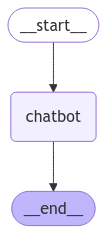

In [64]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [65]:
prompt = ChatPromptTemplate.from_messages([("human", "Write a haiku about {topic}")])
chain = prompt | llm
for chunk in chain.stream({"topic": "The Moon"}):
    print(chunk.content, end="", flush=True)

Silvery glow bright
Moon's gentle light on my face
Peaceful night's delight

In [66]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi
Assistant: I'm happy to help! However, it seems like you've provided some variables that don't seem to be related to a specific task or question. Could you please provide more context or clarify what you'd like me to assist you with?

If you'd like, I can suggest some possible tasks or questions that I can help you with. For example, I can help you:

* Generate a response based on the content you provided
* Provide information on a specific topic
* Assist with a language-related task, such as translation or grammar correction
* Help with a creative task, such as writing or brainstorming

Please let me know how I can assist you today!
User: i want you tell me about federated learning 
Assistant: Federated Learning (FL) is a distributed machine learning approach that enables multiple organizations or entities to jointly train a machine learning model on their local data without sharing the data itself. This approach has gained significant attention in recent years due to its pot